In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import statistics

In [29]:
df = pd.read_csv(f'./data/2015-2024_apiGameScores.csv')
df

,date,visitor,home,visitor_points,home_points
0,2015-11-24,Boston Celtics,Atlanta Hawks,97.0,121.0
1,2016-04-09,Boston Celtics,Atlanta Hawks,107.0,118.0
2,2016-04-16,Boston Celtics,Atlanta Hawks,101.0,102.0
3,2016-04-19,Boston Celtics,Atlanta Hawks,72.0,89.0
4,2016-04-26,Boston Celtics,Atlanta Hawks,83.0,110.0
...,...,...,...,...,...
12791,2020-02-28,Washington Wizards,Utah Jazz,119.0,129.0
12792,2021-04-12,Washington Wizards,Utah Jazz,125.0,121.0
12793,2021-12-18,Washington Wizards,Utah Jazz,109.0,103.0
12794,2022-12-22,Washington Wizards,Utah Jazz,112.0,120.0


In [30]:
# Take games between chosen years
start_year = 2018
current_year = dt.datetime.now().year

# Convert to datetime data type
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Filtered the dataframe for games between start year and current year
filtered_df = df[(df['date'].dt.year >= start_year) & (df['date'].dt.year <= current_year)]

# Reset data frame
filtered_df = filtered_df.reset_index(drop=True)
filtered_df

,date,visitor,home,visitor_points,home_points
0,2018-11-23,Boston Celtics,Atlanta Hawks,114.0,96.0
1,2019-01-19,Boston Celtics,Atlanta Hawks,113.0,105.0
2,2020-02-03,Boston Celtics,Atlanta Hawks,123.0,115.0
3,2021-02-24,Boston Celtics,Atlanta Hawks,112.0,127.0
4,2021-08-08,Boston Celtics,Atlanta Hawks,85.0,83.0
...,...,...,...,...,...
9282,2020-02-28,Washington Wizards,Utah Jazz,119.0,129.0
9283,2021-04-12,Washington Wizards,Utah Jazz,125.0,121.0
9284,2021-12-18,Washington Wizards,Utah Jazz,109.0,103.0
9285,2022-12-22,Washington Wizards,Utah Jazz,112.0,120.0


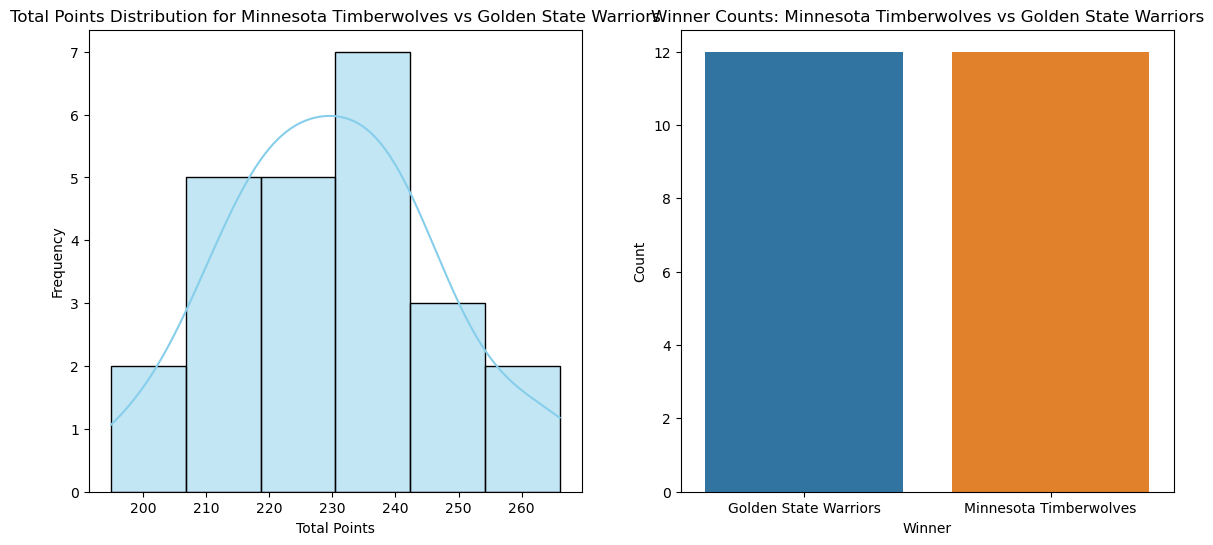

Statistics of Minnesota Timberwolves vs Golden State Warriors


Mean: 229.92
Standard Deviation: 16.92
------------------------------------
z-score for 205.0: -1.47
z-score for 206.0: -1.41
z-score for 207.0: -1.35
z-score for 208.0: -1.30
z-score for 209.0: -1.24
z-score for 210.0: -1.18
z-score for 211.0: -1.12
z-score for 212.0: -1.06
z-score for 213.0: -1.00
z-score for 214.0: -0.94
z-score for 215.0: -0.88
z-score for 216.0: -0.82
z-score for 217.0: -0.76
z-score for 218.0: -0.70
z-score for 219.0: -0.65
z-score for 220.0: -0.59
z-score for 221.0: -0.53
z-score for 222.0: -0.47
z-score for 223.0: -0.41
z-score for 224.0: -0.35


,date,visitor,home,visitor_points,home_points,total_points,winner
0,2018-01-25,Minnesota Timberwolves,Golden State Warriors,113.0,126.0,239.0,Golden State Warriors
1,2018-03-11,Golden State Warriors,Minnesota Timberwolves,103.0,109.0,212.0,Minnesota Timberwolves
2,2018-09-29,Minnesota Timberwolves,Golden State Warriors,114.0,110.0,224.0,Minnesota Timberwolves
3,2018-11-02,Minnesota Timberwolves,Golden State Warriors,99.0,116.0,215.0,Golden State Warriors
4,2018-12-10,Minnesota Timberwolves,Golden State Warriors,108.0,116.0,224.0,Golden State Warriors
5,2019-03-19,Golden State Warriors,Minnesota Timberwolves,117.0,107.0,224.0,Golden State Warriors
6,2019-03-29,Golden State Warriors,Minnesota Timberwolves,130.0,131.0,261.0,Minnesota Timberwolves
7,2019-10-10,Minnesota Timberwolves,Golden State Warriors,123.0,143.0,266.0,Golden State Warriors
8,2019-11-08,Golden State Warriors,Minnesota Timberwolves,119.0,125.0,244.0,Minnesota Timberwolves
9,2019-12-23,Minnesota Timberwolves,Golden State Warriors,104.0,113.0,217.0,Golden State Warriors


In [35]:
def possible_outcome(dataframe, away_team, home_team, first_line): 
    # Filter the dataframe for the specific matchup
    matchup_game = dataframe.loc[
        ((dataframe['visitor'] == away_team) & (dataframe['home'] == home_team)) | 
        ((dataframe['visitor'] == home_team) & (dataframe['home'] == away_team))
        ].copy()
    
    # Add a 'total_points' column 
    matchup_game['total_points'] = matchup_game['visitor_points'] + matchup_game['home_points']
    
    # Sort by date
    matchup_game = matchup_game.sort_values(by='date').reset_index(drop=True)
    
    # Determine the winner
    matchup_game['winner'] = matchup_game.apply(
        lambda row: row['home'] if row['home_points'] > row['visitor_points'] else row['visitor'], 
        axis=1
    )
    
    # Filter out postponed games(with zero total points)
    matchup_game = matchup_game.loc[matchup_game['total_points'] != 0]


    # Calculate Q1, Q3 and IQR
    Q1 = matchup_game['total_points'].quantile(0.25)
    Q3 = matchup_game['total_points'].quantile(0.75)
    IQR = Q3 - Q1

    # Define outlier thresholds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter games where total points are not outliers
    # Create matches dataframe
    matches = matchup_game[(matchup_game['total_points'] >= lower_bound) & (matchup_game['total_points'] <= upper_bound)]
    matches = matches.reset_index(drop=True)
        
    # Create side-by-side plots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
      
    # Plot total points distribution with a KDE
    sns.histplot(data=matches, x ='total_points', kde=True, ax=axes[0], color="skyblue")
    axes[0].set_title(f'Total Points Distribution for {away_team} vs {home_team}')
    axes[0].set_xlabel('Total Points')
    axes[0].set_ylabel('Frequency')
    
    # Plot the winner count    
    sns.countplot(data=matches, x='winner', ax=axes[1], hue='winner')
    axes[1].set_title(f'Winner Counts: {away_team} vs {home_team}')
    axes[1].set_xlabel('Winner')
    axes[1].set_ylabel('Count')
        
    # Display the plots
    plt.show()
    
     # Calculate a z-score from a provided mean and standard deviation
    mean = matches['total_points'].mean()
    standard_deviation = matches['total_points'].std()
   
    # Create array of UNDER/OVER values based first line
    under_over_lines = [first_line + i for i in range(-10, 10)]
    
    # Display basic statics of team matchup
    print(f'Statistics of {away_team} vs {home_team}')
    print('\n')
    print(f'Mean: {mean:.2f}')
    print(f'Standard Deviation: {standard_deviation:.2f}')

    print('------------------------------------')
    # Display the z-scores for each line score
    for line in under_over_lines:
        zscore = statistics.NormalDist(mean, standard_deviation).zscore(line)
        print(f'z-score for {line}: {zscore:.2f}')

    # print('------------------------------------')

    # Find percentage of games between specified range
    # total_games = len(matchup_game)
    # games_in_range = matchup_game[(matchup_game['total_points'] >= lower_bound) & (matchup_game['total_points'] <= upper_bound)]
    # percentage = (len(games_in_range) / total_games) * 100
    # print(f"Percentage of games with total scores between {lower_bound} and {upper_bound}: {percentage:.2f}%")
    # print('------------------------------------')
    
    return matches

away_team = input("Enter the away team: ")
home_team = input("Enter the home team: ")
first_line = float(input("Enter the first line for the over/under bet: "))


possible_outcome(filtered_df, away_team, home_team, first_line)